In [35]:
import pandas as pd
import numpy as np
from scipy.stats import norm, chi2
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib as mpl

In [2]:
df1 = pd.read_csv(('gradient_boost_optimise_results.csv' ))
print(df1)

          y_true    y_pred  y_transformed          lon         lat
0      -0.416573 -0.893819      -0.893819   733918.149 -2611525.25
1      -0.286116 -0.867605      -0.867605   733576.615 -2611507.22
2      -0.326302 -0.664411      -0.664411   733235.911 -2611485.23
3      -0.430061 -0.826153      -0.826153   732898.186 -2611471.29
4      -0.620153 -1.114811      -1.114811   732564.331 -2611446.62
...          ...       ...            ...          ...         ...
259002 -1.506235 -1.822296      -1.822296   503053.300 -2177707.38
259003 -0.783225 -0.870340      -0.870340   543295.125 -2177704.15
259004 -1.517741 -1.325385      -1.325385   321851.553 -2177701.95
259005 -2.651306 -2.529641      -2.529641 -1080456.310 -2177688.38
259006 -2.352128 -1.783645      -1.783645 -1155306.740 -2177675.01

[259007 rows x 5 columns]


In [3]:
df2 = df1[["y_true", "y_pred"]]
var1 = df2.var
print(var1)

<bound method DataFrame.var of           y_true    y_pred
0      -0.416573 -0.893819
1      -0.286116 -0.867605
2      -0.326302 -0.664411
3      -0.430061 -0.826153
4      -0.620153 -1.114811
...          ...       ...
259002 -1.506235 -1.822296
259003 -0.783225 -0.870340
259004 -1.517741 -1.325385
259005 -2.651306 -2.529641
259006 -2.352128 -1.783645

[259007 rows x 2 columns]>


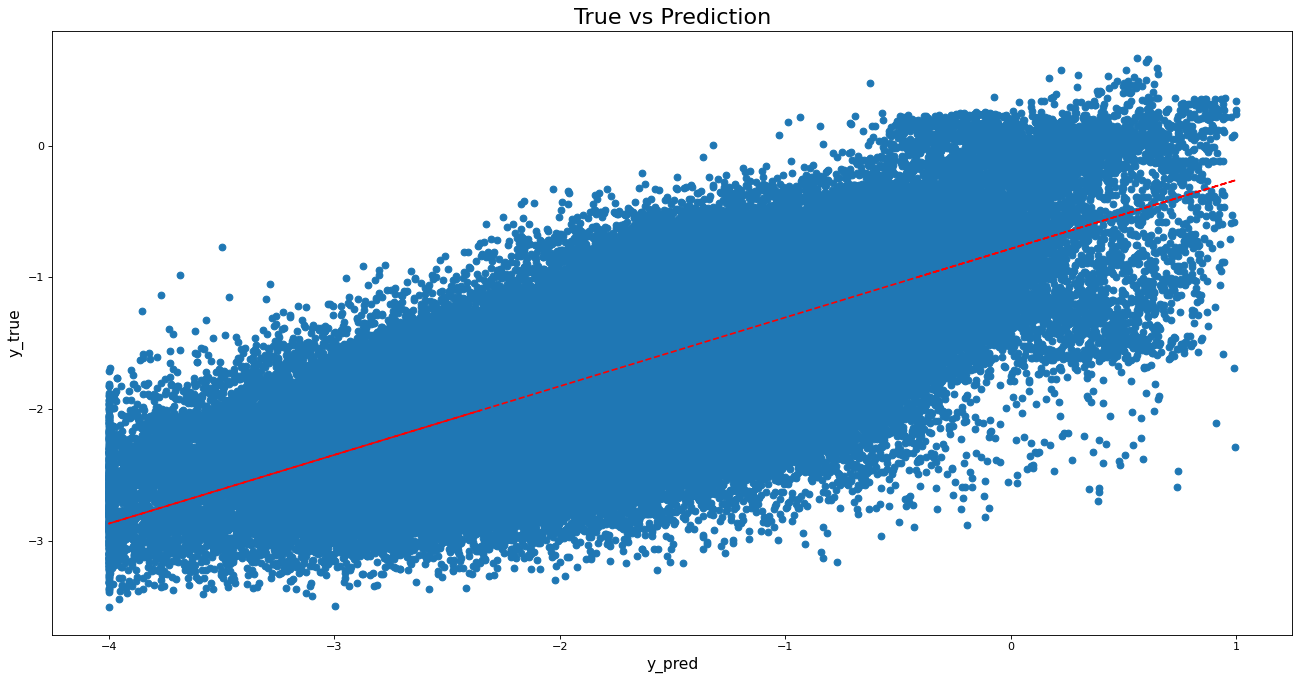

In [45]:
figure(figsize=(20, 10), dpi=80)
plt.plot(x,y,'o')
plt.xlabel("y_pred", fontsize=14)
plt.ylabel("y_true", fontsize=14)
plt.title("True vs Prediction", fontsize=20)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

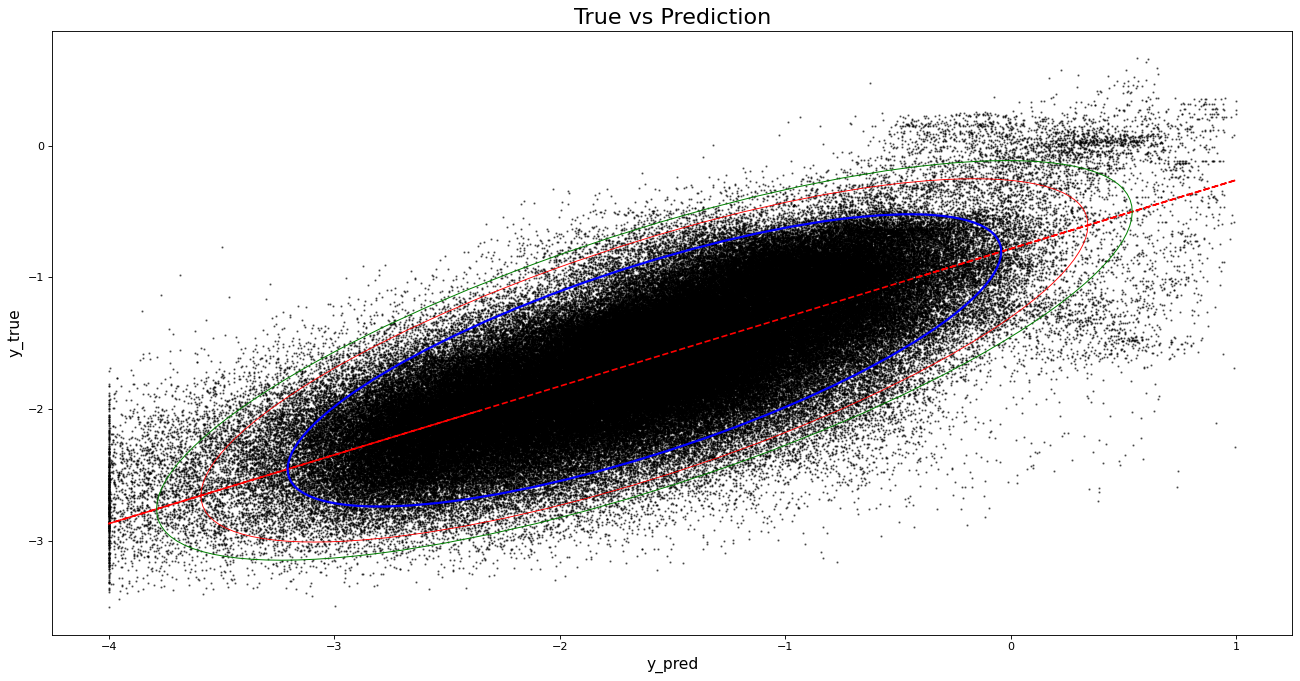

In [82]:
figure(figsize=(20, 10), dpi=80)

def main(nstd=2.):
    """
    Generate an `nstd` sigma ellipse based on the mean and covariance of a
    point "cloud".
    """

    # Generate some random, correlated data
    points = df2
    # The 2x2 covariance matrix to base the ellipse on.
    cov = np.cov(points, rowvar=False)

    # Location of the center of the ellipse.
    mean_pos = points.mean(axis=0)

    # METHOD 1
    width1, height1, theta1 = cov_ellipse(points, cov, nstd)

    # METHOD 2
    width2, height2, theta2 = cov_ellipse2(points, cov, nstd)
    
    #METHOD 3
    width3, height3, theta3 = cov_ellipse3(points, cov, nstd)

    # Plot the raw points.
    df1["y_true"], df1["y_pred"]
    ax = plt.gca()
    plt.scatter(x, y, c='k', s=1, alpha=.5)
    plt.xlabel("y_pred", fontsize=14)
    plt.ylabel("y_true", fontsize=14)
    plt.title("True vs Prediction", fontsize=20)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    
    # First ellipse
    ellipse1 = Ellipse(xy=mean_pos, width=width1, height=height1, angle=theta1,
                       edgecolor='b', fc='None', lw=2, zorder=4)
    ax.add_patch(ellipse1)
    # Second ellipse
    ellipse2 = Ellipse(xy=mean_pos, width=width2, height=height2, angle=theta2,
                       edgecolor='r', fc='None', lw=.8, zorder=4)
    ax.add_patch(ellipse2)
    
    #Third ellipse
    ellipse3 = Ellipse(xy=mean_pos, width=width3, height=height3, angle=theta3,
                       edgecolor='g', fc='None', lw=.9, zorder=4)
    ax.add_patch(ellipse3)
    plt.show()


def eigsorted(cov):
    '''
    Eigenvalues and eigenvectors of the covariance matrix.
    '''
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]


def cov_ellipse(points, cov, nstd):
    """
    Source: http://stackoverflow.com/a/12321306/1391441
    """

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)

    return width, height, theta


def cov_ellipse2(points, cov, nstd):
    """
    Source: https://stackoverflow.com/a/39749274/1391441
    """

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[::-1, 0]))

    # Confidence level
    q = 2 * norm.cdf(nstd) - 1
    r2 = chi2.ppf(q, 2)

    width, height = 2 * np.sqrt(vals * r2)

    return width, height, theta


def cov_ellipse3(points, cov, nstd):
    """
    Source: https://stackoverflow.com/a/39749274/1391441
    """

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[::-1, -0]))

    # Confidence level
    q = 2 * norm.cdf(nstd) - 1
    r2 = chi2.ppf(q, 2)

    width, height = 2.2 *np.sqrt(vals * r2)

    return width, height, theta


if __name__ == '__main__':
    main()